# Cross-Model Style Evaluation

This notebook evaluates reconstructions across different **model × prompting method** combinations.

## Methodology

Unlike the single-experiment evaluation in `style_evaluation.ipynb`, this notebook:

1. **Pulls reconstructions** from multiple existing evaluation databases
2. **Combines** them into unified comparison sets (e.g., Mistral+fewshot vs Kimi+fewshot vs Mistral+agent_statistical)
3. **Runs random 4-way comparisons**: For each sample, randomly sample 4 combinations and judge them
4. **Aggregates** using Bradley-Terry model to estimate strength of each combination

## Advantages over Pairwise ELO

- **More information per judgment**: 4-way ranking > pairwise comparison
- **Statistically principled**: Bradley-Terry gives confidence intervals and p-values
- **Efficient**: O(k*n) comparisons instead of O(n²) pairwise round-robin
- **Reuses existing infrastructure**: Same judge prompts and 4-way ranking code

## Prerequisites

You must have already run `style_evaluation.ipynb` with different reconstruction models to generate source databases.

## Setup

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime

from belletrist import (
    LLM, LLMConfig, PromptMaker,
    CrossModelComparisonStore, Combination
)

## Configuration

### 1. Specify which combinations to compare

Each `Combination` specifies:
- `db_path`: Path to evaluation database
- `method`: Reconstruction method (e.g., 'fewshot', 'agent_statistical')
- `label`: Unique identifier for this combination (e.g., 'mistral_fewshot')
- `reconstruction_run`: Which run to use (default 0)

In [2]:
# Compare fewshot, agent_statistical, and author across three reconstruction models
combinations = [
    # Mistral reconstructions
    Combination(
        db_path=Path("style_eval_statistical_s_mistral_r_mistral_j_anthropic.db"),
        method="fewshot",
        label="mistral_fewshot"
    ),
    Combination(
        db_path=Path("style_eval_statistical_s_mistral_r_mistral_j_anthropic.db"),
        method="agent_statistical",
        label="mistral_agent_statistical"
    ),
    Combination(
        db_path=Path("style_eval_statistical_s_mistral_r_mistral_j_anthropic.db"),
        method="author",
        label="mistral_author"
    ),
    
    # OpenAI reconstructions
    Combination(
        db_path=Path("style_eval_statistical_s_mistral_r_openai_j_anthropic.db"),
        method="fewshot",
        label="openai_fewshot"
    ),
    Combination(
        db_path=Path("style_eval_statistical_s_mistral_r_openai_j_anthropic.db"),
        method="agent_statistical",
        label="openai_agent_statistical"
    ),
    Combination(
        db_path=Path("style_eval_statistical_s_mistral_r_openai_j_anthropic.db"),
        method="author",
        label="openai_author"
    ),
    
    # Qwen reconstructions
    Combination(
        db_path=Path("style_eval_statistical_s_mistral_r_qwen_j_anthropic.db"),
        method="fewshot",
        label="qwen_fewshot"
    ),
    Combination(
        db_path=Path("style_eval_statistical_s_mistral_r_qwen_j_anthropic.db"),
        method="agent_statistical",
        label="qwen_agent_statistical"
    ),
    Combination(
        db_path=Path("style_eval_statistical_s_mistral_r_qwen_j_anthropic.db"),
        method="author",
        label="qwen_author"
    ),
]

# Verify all databases exist
for combo in combinations:
    if not combo.db_path.exists():
        raise FileNotFoundError(f"Database not found: {combo.db_path}")

print(f"Configured {len(combinations)} combinations:")
for combo in combinations:
    print(f"  {combo.label:25s} = {combo.db_path.name} / {combo.method}")

Configured 9 combinations:
  mistral_fewshot           = style_eval_statistical_s_mistral_r_mistral_j_anthropic.db / fewshot
  mistral_agent_statistical = style_eval_statistical_s_mistral_r_mistral_j_anthropic.db / agent_statistical
  mistral_author            = style_eval_statistical_s_mistral_r_mistral_j_anthropic.db / author
  openai_fewshot            = style_eval_statistical_s_mistral_r_openai_j_anthropic.db / fewshot
  openai_agent_statistical  = style_eval_statistical_s_mistral_r_openai_j_anthropic.db / agent_statistical
  openai_author             = style_eval_statistical_s_mistral_r_openai_j_anthropic.db / author
  qwen_fewshot              = style_eval_statistical_s_mistral_r_qwen_j_anthropic.db / fewshot
  qwen_agent_statistical    = style_eval_statistical_s_mistral_r_qwen_j_anthropic.db / agent_statistical
  qwen_author               = style_eval_statistical_s_mistral_r_qwen_j_anthropic.db / author


### 2. Configure judge LLM and comparison parameters

In [3]:
# Judge LLM configuration
JUDGE_MODEL = 'anthropic/claude-sonnet-4-5-20250929'
JUDGE_API_KEY_ENV_VAR = 'ANTHROPIC_API_KEY'
#JUDGE_MODEL = 'mistral/mistral-large-2512'
#JUDGE_API_KEY_ENV_VAR = 'MISTRAL_API_KEY'

# Comparison parameters
N_COMPARISONS_PER_SAMPLE = 6  # How many random 4-way comparisons per sample
RANDOM_SEED = 42  # For reproducibility

# Output database
OUTPUT_DB = Path(f"cross_eval_{datetime.now().strftime('%Y%m%d_%H%M%S')}.db")
#OUTPUT_DB = Path("cross_eval_20251215_110004.db")

print(f"Judge: {JUDGE_MODEL}")
print(f"Comparisons per sample: {N_COMPARISONS_PER_SAMPLE}")
print(f"Output: {OUTPUT_DB}")

Judge: anthropic/claude-sonnet-4-5-20250929
Comparisons per sample: 6
Output: cross_eval_20251219_112242.db


## Initialize Components

In [4]:
# Initialize judge LLM
judge_llm = LLM(LLMConfig(
    model=JUDGE_MODEL,
    api_key=os.environ.get(JUDGE_API_KEY_ENV_VAR)
))

# Initialize prompt maker
prompt_maker = PromptMaker()

# Initialize comparison store
comparer = CrossModelComparisonStore(
    output_db=OUTPUT_DB,
    combinations=combinations
)

print("✓ Components initialized")

✓ Components initialized


## Step 1: Load Reconstructions from Source Databases

Pull reconstructions from all configured databases. This verifies:
- All samples exist in all databases
- Original texts are consistent across databases
- Requested methods exist

In [5]:
# Load all samples (or specify sample_ids=['sample_000', 'sample_001', ...])
comparer.load_reconstructions()

# Check what was loaded
stats = comparer.get_stats()
print(f"\n=== Loaded Reconstructions ===")
print(f"Samples: {stats['n_samples']}")
print(f"Combinations: {stats['n_combinations']}")
print(f"Total reconstructions: {stats['n_samples'] * stats['n_combinations']}")

Loading all 10 samples from source databases

Loading from style_eval_statistical_s_mistral_r_mistral_j_anthropic.db:
  ✓ mistral_fewshot                - sample_000
  ✓ mistral_agent_statistical      - sample_000
  ✓ mistral_author                 - sample_000
  ✓ mistral_fewshot                - sample_001
  ✓ mistral_agent_statistical      - sample_001
  ✓ mistral_author                 - sample_001
  ✓ mistral_fewshot                - sample_002
  ✓ mistral_agent_statistical      - sample_002
  ✓ mistral_author                 - sample_002
  ✓ mistral_fewshot                - sample_003
  ✓ mistral_agent_statistical      - sample_003
  ✓ mistral_author                 - sample_003
  ✓ mistral_fewshot                - sample_004
  ✓ mistral_agent_statistical      - sample_004
  ✓ mistral_author                 - sample_004
  ✓ mistral_fewshot                - sample_005
  ✓ mistral_agent_statistical      - sample_005
  ✓ mistral_author                 - sample_005
  ✓ mistral_fewsho

## Step 2: Run Random 4-Way Comparisons

For each sample, randomly sample `N_COMPARISONS_PER_SAMPLE` sets of 4 combinations and judge them.

This generates `n_samples × N_COMPARISONS_PER_SAMPLE` judgments total.

**Note:** This step calls the LLM judge and may take some time.

In [6]:
comparer.run_comparisons(
    judge_llm=judge_llm,
    prompt_maker=prompt_maker,
    n_comparisons_per_sample=N_COMPARISONS_PER_SAMPLE,
    seed=RANDOM_SEED
)

stats = comparer.get_stats()
print(f"\n=== Comparison Complete ===")
print(f"Total judgments: {stats['n_judgments']}")
print(f"Expected: {stats['n_samples'] * N_COMPARISONS_PER_SAMPLE}")

=== Running 6 comparisons × 10 samples = 60 total ===


sample_000:
  Comparison 0: Sampling 4 combinations... [mistral_author, openai_author, mistral_agent_statistical, mistral_fewshot]
    Judging... ✓ (confidence: high)
  Comparison 1: Sampling 4 combinations... [qwen_author, openai_agent_statistical, openai_fewshot, mistral_agent_statistical]
    Judging... ✓ (confidence: high)
  Comparison 2: Sampling 4 combinations... [qwen_author, qwen_fewshot, openai_agent_statistical, openai_fewshot]
    Judging... ✓ (confidence: high)
  Comparison 3: Sampling 4 combinations... [qwen_fewshot, openai_fewshot, qwen_author, mistral_agent_statistical]
    Judging... ✓ (confidence: high)
  Comparison 4: Sampling 4 combinations... [mistral_author, qwen_fewshot, mistral_agent_statistical, openai_author]
    Judging... ✓ (confidence: high)
  Comparison 5: Sampling 4 combinations... [mistral_agent_statistical, qwen_fewshot, mistral_author, mistral_fewshot]
    Judging... ✓ (confidence: high)

sample_00

    Judging... ✓ (confidence: high)
  Comparison 4: Sampling 4 combinations... [qwen_fewshot, openai_agent_statistical, mistral_fewshot, qwen_author]
    Judging... ✓ (confidence: high)
  Comparison 5: Sampling 4 combinations... [qwen_fewshot, qwen_author, mistral_author, mistral_fewshot]
    Judging... ✓ (confidence: high)

sample_009:
  Comparison 0: Sampling 4 combinations... [openai_agent_statistical, qwen_author, mistral_fewshot, mistral_author]
    Judging... ✓ (confidence: high)
  Comparison 1: Sampling 4 combinations... [openai_author, mistral_agent_statistical, qwen_fewshot, openai_agent_statistical]
    Judging... ✓ (confidence: high)
  Comparison 2: Sampling 4 combinations... [mistral_author, qwen_fewshot, openai_fewshot, mistral_agent_statistical]
    Judging... ✓ (confidence: high)
  Comparison 3: Sampling 4 combinations... [qwen_agent_statistical, openai_author, qwen_author, qwen_fewshot]
    Judging... ✓ (confidence: high)
  Comparison 4: Sampling 4 combinations... [qwen

## Step 3: Export Results

In [7]:
# Export full judgment data
df_judgments = comparer.to_dataframe()

print(f"Total judgments: {len(df_judgments)}")
print(f"\n=== Sample Judgments ===")
display_cols = [
    'sample_id', 'comparison_run',
    'label_text_a', 'label_text_b', 'label_text_c', 'label_text_d',
    'ranking_text_a', 'ranking_text_b', 'ranking_text_c', 'ranking_text_d',
    'confidence'
]
print(df_judgments[display_cols].head(10))

# Save to CSV
output_csv = OUTPUT_DB.with_suffix('.csv')
df_judgments.to_csv(output_csv, index=False)
print(f"\n✓ Saved to {output_csv}")

Total judgments: 60

=== Sample Judgments ===
    sample_id  comparison_run               label_text_a  \
0  sample_000               0             mistral_author   
1  sample_000               1                qwen_author   
2  sample_000               2                qwen_author   
3  sample_000               3               qwen_fewshot   
4  sample_000               4             mistral_author   
5  sample_000               5  mistral_agent_statistical   
6  sample_001               0   openai_agent_statistical   
7  sample_001               1             openai_fewshot   
8  sample_001               2     qwen_agent_statistical   
9  sample_001               3             mistral_author   

               label_text_b               label_text_c  \
0             openai_author  mistral_agent_statistical   
1  openai_agent_statistical             openai_fewshot   
2              qwen_fewshot   openai_agent_statistical   
3            openai_fewshot                qwen_author   
4  

In [8]:
# Export Bradley-Terry format (pairwise preferences)
df_bt = comparer.to_bradley_terry_format()

print(f"\n=== Bradley-Terry Format ===")
print(f"Total pairwise preferences: {len(df_bt)}")
print(f"\nSample rows:")
print(df_bt.head(10))

# Save Bradley-Terry data
bt_csv = OUTPUT_DB.with_suffix('.bt.csv')
df_bt.to_csv(bt_csv, index=False)
print(f"\n✓ Saved to {bt_csv}")


=== Bradley-Terry Format ===
Total pairwise preferences: 360

Sample rows:
                      winner                      loser   sample_id  \
0              openai_author             mistral_author  sample_000   
1  mistral_agent_statistical             mistral_author  sample_000   
2             mistral_author            mistral_fewshot  sample_000   
3              openai_author  mistral_agent_statistical  sample_000   
4              openai_author            mistral_fewshot  sample_000   
5  mistral_agent_statistical            mistral_fewshot  sample_000   
6   openai_agent_statistical                qwen_author  sample_000   
7             openai_fewshot                qwen_author  sample_000   
8                qwen_author  mistral_agent_statistical  sample_000   
9   openai_agent_statistical             openai_fewshot  sample_000   

   comparison_run  
0               0  
1               0  
2               0  
3               0  
4               0  
5               0  
6 

## Step 4: Bradley-Terry Analysis

Fit a Bradley-Terry model to estimate the "strength" of each combination.

Bradley-Terry models pairwise preferences as:
$$P(i > j) = \frac{\pi_i}{\pi_i + \pi_j}$$

where $\pi_i$ is the strength parameter for combination $i$.

We'll use iterative maximum likelihood estimation (MM algorithm).

In [9]:
def fit_bradley_terry(df_pairs, max_iter=100, tol=1e-6):
    """
    Fit Bradley-Terry model using MM algorithm.
    
    Args:
        df_pairs: DataFrame with 'winner' and 'loser' columns
        max_iter: Maximum iterations
        tol: Convergence tolerance
    
    Returns:
        DataFrame with columns: label, strength, log_strength
    """
    # Count wins for each pair
    wins = df_pairs.groupby(['winner', 'loser']).size().reset_index(name='count')
    
    # Get all unique labels
    labels = sorted(set(df_pairs['winner']) | set(df_pairs['loser']))
    n = len(labels)
    label_to_idx = {label: i for i, label in enumerate(labels)}
    
    # Initialize strengths uniformly
    pi = np.ones(n)
    
    # Build win matrix W[i,j] = number of times i beat j
    W = np.zeros((n, n))
    for _, row in wins.iterrows():
        i = label_to_idx[row['winner']]
        j = label_to_idx[row['loser']]
        W[i, j] = row['count']
    
    # Total WINS by each item (not total comparisons!)
    total_wins = W.sum(axis=1)
    
    # Total comparisons involving each item (for reporting only)
    n_comparisons = W.sum(axis=1) + W.sum(axis=0)
    
    # MM algorithm
    for iteration in range(max_iter):
        pi_old = pi.copy()
        
        # Update each strength parameter
        for i in range(n):
            if n_comparisons[i] == 0:
                continue
            
            # Sum of 1/(pi_i + pi_j) over all j that i played against
            denom = 0
            for j in range(n):
                if i == j:
                    continue
                n_ij = W[i, j] + W[j, i]  # Total matches between i and j
                if n_ij > 0:
                    denom += n_ij / (pi_old[i] + pi_old[j])
            
            if denom > 0:
                pi[i] = total_wins[i] / denom  # FIX: Use total_wins, not n_comparisons
        
        # Normalize to prevent drift
        pi = pi / pi.sum() * n
        
        # Check convergence
        if np.max(np.abs(pi - pi_old)) < tol:
            print(f"Converged in {iteration + 1} iterations")
            break
    
    # Build results DataFrame
    results = pd.DataFrame({
        'label': labels,
        'strength': pi,
        'log_strength': np.log(pi),
        'n_comparisons': n_comparisons
    })
    
    return results.sort_values('strength', ascending=False).reset_index(drop=True)

# Fit model
bt_results = fit_bradley_terry(df_bt)

print("\n=== Bradley-Terry Rankings ===")
print(bt_results)


=== Bradley-Terry Rankings ===
                       label  strength  log_strength  n_comparisons
0   openai_agent_statistical  5.418445      1.689809           69.0
1             openai_fewshot  1.746611      0.557677           75.0
2              openai_author  1.350662      0.300595           78.0
3               qwen_fewshot  0.280956     -1.269558           87.0
4     qwen_agent_statistical  0.097222     -2.330757           69.0
5                qwen_author  0.065514     -2.725498           78.0
6  mistral_agent_statistical  0.022530     -3.792889          105.0
7             mistral_author  0.014314     -4.246518           72.0
8            mistral_fewshot  0.003747     -5.586911           87.0


## Step 5: Visualization

Visualize the Bradley-Terry strength estimates.

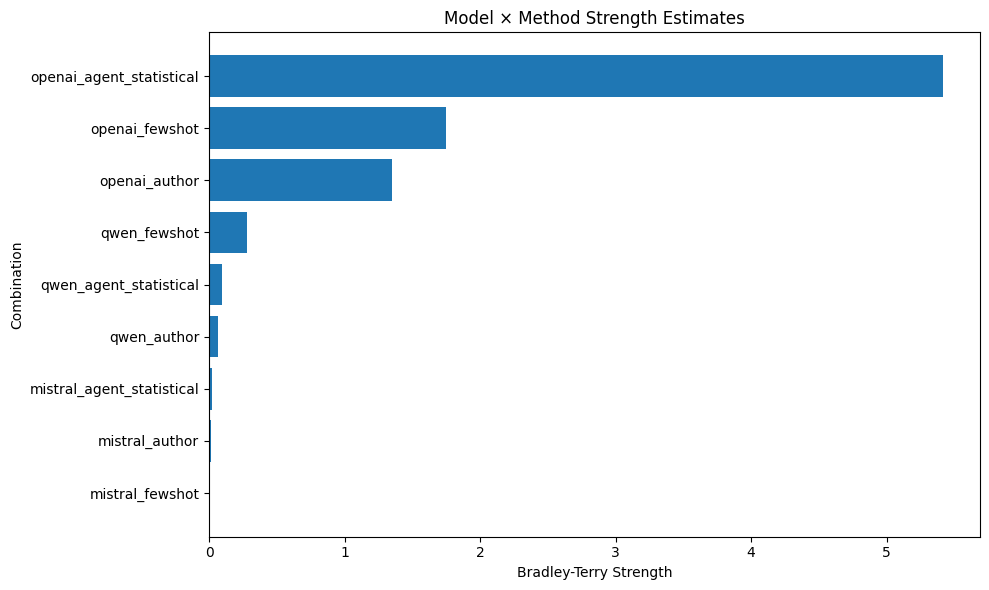

In [10]:
import matplotlib.pyplot as plt

# Bar chart of strengths
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(bt_results['label'], bt_results['strength'])
ax.set_xlabel('Bradley-Terry Strength')
ax.set_ylabel('Combination')
ax.set_title('Model × Method Strength Estimates')
ax.invert_yaxis()  # Best at top

plt.tight_layout()
plt.show()

## Step 6: Win Rate Matrix

Show pairwise win rates for interpretability.

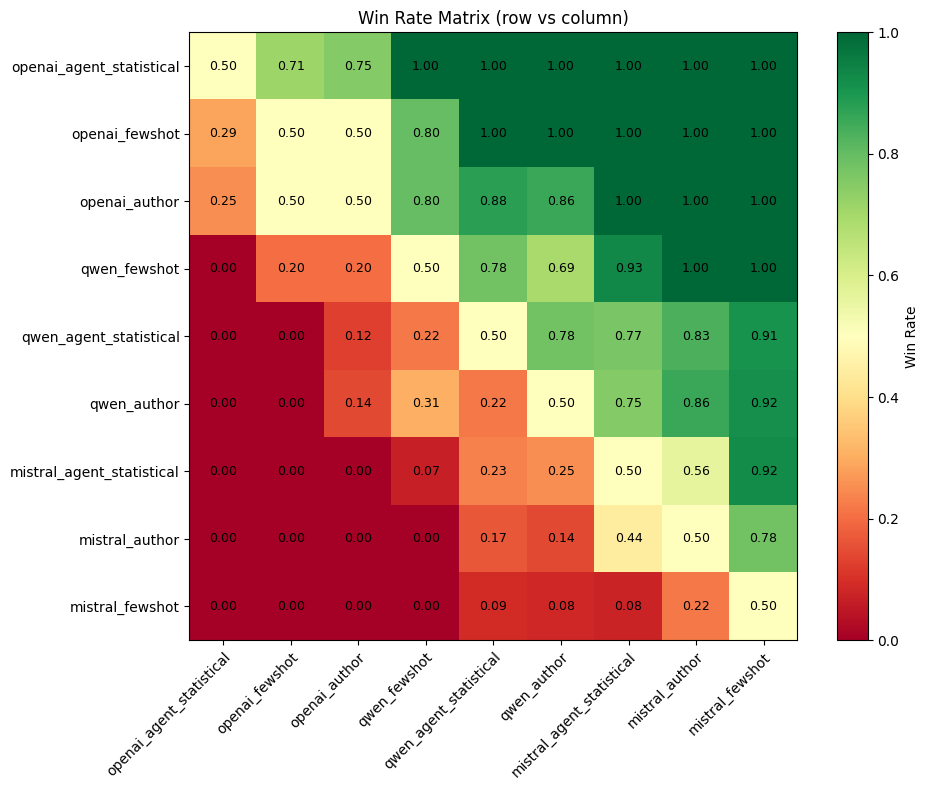


Interpretation: Cell (i, j) shows how often combination i beats combination j.
Green = high win rate, Red = low win rate


In [11]:
# Calculate win rate matrix
labels = bt_results['label'].tolist()
n = len(labels)

win_matrix = np.zeros((n, n))

for i, label_i in enumerate(labels):
    for j, label_j in enumerate(labels):
        if i == j:
            win_matrix[i, j] = 0.5  # Diagonal
            continue
        
        # Count wins
        wins_i = len(df_bt[(df_bt['winner'] == label_i) & (df_bt['loser'] == label_j)])
        wins_j = len(df_bt[(df_bt['winner'] == label_j) & (df_bt['loser'] == label_i)])
        total = wins_i + wins_j
        
        if total > 0:
            win_matrix[i, j] = wins_i / total
        else:
            win_matrix[i, j] = 0.5  # No data

# Visualize as heatmap
fig, ax = plt.subplots(figsize=(10, 8))

im = ax.imshow(win_matrix, cmap='RdYlGn', vmin=0, vmax=1)

# Labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate x labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells
for i in range(n):
    for j in range(n):
        text = ax.text(j, i, f"{win_matrix[i, j]:.2f}",
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title("Win Rate Matrix (row vs column)")
fig.colorbar(im, ax=ax, label='Win Rate')
plt.tight_layout()
plt.show()

print("\nInterpretation: Cell (i, j) shows how often combination i beats combination j.")
print("Green = high win rate, Red = low win rate")

## Step 7: Statistical Summary

Compute additional statistics for each combination.

In [12]:
# Calculate statistics for each combination
stats_records = []

for label in labels:
    # Total wins and losses
    wins = len(df_bt[df_bt['winner'] == label])
    losses = len(df_bt[df_bt['loser'] == label])
    total = wins + losses
    
    # Win rate
    win_rate = wins / total if total > 0 else 0
    
    # Average rank (from original judgments)
    # Find all judgments involving this label
    ranks = []
    for _, row in df_judgments.iterrows():
        for letter in ['a', 'b', 'c', 'd']:
            if row[f'label_text_{letter}'] == label:
                ranks.append(row[f'ranking_text_{letter}'])
    
    avg_rank = np.mean(ranks) if ranks else np.nan
    
    # Get BT strength
    bt_strength = bt_results[bt_results['label'] == label]['strength'].values[0]
    
    stats_records.append({
        'label': label,
        'bt_strength': bt_strength,
        'win_rate': win_rate,
        'avg_rank': avg_rank,
        'total_wins': wins,
        'total_losses': losses,
        'n_judgments': len(ranks)
    })

df_stats = pd.DataFrame(stats_records).sort_values('bt_strength', ascending=False)

print("\n=== Comprehensive Statistics ===")
print(df_stats.to_string(index=False))

# Save stats
stats_csv = OUTPUT_DB.with_suffix('.stats.csv')
df_stats.to_csv(stats_csv, index=False)
print(f"\n✓ Saved to {stats_csv}")


=== Comprehensive Statistics ===
                    label  bt_strength  win_rate  avg_rank  total_wins  total_losses  n_judgments
 openai_agent_statistical     5.418445  0.942029  1.173913          65             4           23
           openai_fewshot     1.746611  0.840000  1.480000          63            12           25
            openai_author     1.350662  0.807692  1.576923          63            15           26
             qwen_fewshot     0.280956  0.643678  2.068966          56            31           29
   qwen_agent_statistical     0.097222  0.507246  2.478261          35            34           23
              qwen_author     0.065514  0.384615  2.846154          30            48           26
mistral_agent_statistical     0.022530  0.257143  3.228571          27            78           35
           mistral_author     0.014314  0.222222  3.333333          16            56           24
          mistral_fewshot     0.003747  0.057471  3.827586           5            82

## Step 8. Inspection

In [19]:
# Inspect a specific judgment
INSPECT_SAMPLE = 'sample_009'
INSPECT_COMPARISON_RUN = 1

# Query judgment directly from database
judgment = comparer.conn.execute("""
    SELECT * FROM comparative_judgments
    WHERE sample_id=? AND comparison_run=?
""", (INSPECT_SAMPLE, INSPECT_COMPARISON_RUN)).fetchone()

if judgment:
    print(f"=== JUDGE REASONING: {INSPECT_SAMPLE}, Comparison {INSPECT_COMPARISON_RUN} ===\n")

    # Build mapping to show which label = which combination
    label_to_rank = {
        'A': judgment['ranking_text_a'],
        'B': judgment['ranking_text_b'],
        'C': judgment['ranking_text_c'],
        'D': judgment['ranking_text_d']
    }

    label_to_combo = {
        'A': judgment['label_text_a'],
        'B': judgment['label_text_b'],
        'C': judgment['label_text_c'],
        'D': judgment['label_text_d']
    }

    print("ANONYMOUS LABELS → COMBINATIONS:")
    for label in ['A', 'B', 'C', 'D']:
        combo = label_to_combo[label]
        rank = label_to_rank[label]
        print(f"  Text {label} = {combo:25s} → Rank {rank}")

    print(f"\nConfidence: {judgment['confidence']}")
    print(f"Judge Model: {judgment['judge_model']}")

    # Show reasoning
    print(f"\n{'REASONING':-^80}")
    print(judgment['reasoning'])
else:
    print(f"No judgment found for {INSPECT_SAMPLE}, comparison run {INSPECT_COMPARISON_RUN}")

=== JUDGE REASONING: sample_009, Comparison 1 ===

ANONYMOUS LABELS → COMBINATIONS:
  Text A = openai_author             → Rank 3
  Text B = mistral_agent_statistical → Rank 4
  Text C = qwen_fewshot              → Rank 2
  Text D = openai_agent_statistical  → Rank 1

Confidence: high
Judge Model: claude-sonnet-4-5-20250929

-----------------------------------REASONING------------------------------------
Let me analyze the distinctive voice of the original and compare each reconstruction.

**The Original's Voice:**
The original Russell has a distinctive, conversational yet authoritative tone. Key features include:
- Direct, clear prose with occasional dry wit ("would never be enunciated in real life except by an orator preparing the way for a piece of sophistry")
- Measured confidence with careful hedging ("may well be doubted," "would now be generally admitted")
- A pedagogical rhythm that builds concepts systematically
- Parenthetical asides that feel natural (dates, clarifications)


In [20]:
# View the 4 reconstructions that were compared
INSPECT_SAMPLE = 'sample_009'
INSPECT_COMPARISON_RUN = 1

# Get the judgment to see which labels were compared
judgment = comparer.conn.execute("""
    SELECT * FROM comparative_judgments
    WHERE sample_id=? AND comparison_run=?
""", (INSPECT_SAMPLE, INSPECT_COMPARISON_RUN)).fetchone()

if judgment:
    
    print(f"=== RECONSTRUCTIONS FOR {INSPECT_SAMPLE}, Comparison {INSPECT_COMPARISON_RUN} ===\n")

    # Get labels that were compared
    labels_compared = [
        judgment['label_text_a'],
        judgment['label_text_b'],
        judgment['label_text_c'],
        judgment['label_text_d']
    ]

    # Get original text (same for all)
    original = comparer.get_reconstruction(INSPECT_SAMPLE, labels_compared[0])

    print(f"{'ORIGINAL':-^80}")
    print(original['original_text'])
    print("\n\n")

    # Show each reconstruction
    for letter, label in zip(['A', 'B', 'C', 'D'], labels_compared):
        rec = comparer.get_reconstruction(INSPECT_SAMPLE, label)
        rank_col = f'ranking_text_{letter.lower()}'
        rank = judgment[rank_col]

        print(f"{label.upper()} - {label} (Rank {rank})"+ "-" * (80 - len(label) - 15))
        print(rec['reconstructed_text'])
        print(f"\n({len(rec['reconstructed_text'])} chars, model: {rec['reconstruction_model']})\n")


=== RECONSTRUCTIONS FOR sample_009, Comparison 1 ===

------------------------------------ORIGINAL------------------------------------
Immanuel Kant is generally regarded as the greatest of the modern
philosophers. Though he lived through the Seven Years War and the
French Revolution, he never interrupted his teaching of philosophy at
Königsberg in East Prussia. His most distinctive contribution was the
invention of what he called the 'critical' philosophy, which, assuming
as a datum that there is knowledge of various kinds, inquired how such
knowledge comes to be possible, and deduced, from the answer to this
inquiry, many metaphysical results as to the nature of the world.
Whether these results were valid may well be doubted. But Kant
undoubtedly deserves credit for two things: first, for having perceived
that we have _a priori_ knowledge which is not purely 'analytic', i.e.
such that the opposite would be self-contradictory, and secondly,
for having made evident the philosophical im

## Summary

**Interpretation Guide:**

- **Bradley-Terry Strength**: Higher = better. Represents estimated "ability" to beat other combinations
- **Win Rate**: Proportion of pairwise comparisons won (should correlate with BT strength)
- **Average Rank**: Lower = better (1 = best, 4 = worst in each 4-way comparison)

**Next Steps:**

1. Compare BT rankings to simple average rank to validate model fit
2. Examine judge reasoning for close competitors
3. Bootstrap confidence intervals for BT strengths
4. Run additional comparisons if rankings are unstable